In [1]:
import umap
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from typing import List
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem.rdchem import Mol
from rdkit.Chem.MolStandardize.rdMolStandardize import LargestFragmentChooser
from rdkit import RDLogger

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)
warnings.filterwarnings("ignore")

In [2]:
material = {
    "red":         {0: "#ffebee",1: "#ffcdd2",2: "#ef9a9a",3: "#e57373",4: "#ef5350",5: "#f44336",6: "#e53935",7: "#d32f2f",8: "#c62828",9: "#b71c1c",},
    "pink":        {0: "#fce4ec",1: "#f8bbd0",2: "#f48fb1",3: "#f06292",4: "#ec407a",5: "#e91e63",6: "#d81b60",7: "#c2185b",8: "#ad1457",9: "#880e4f",},
    "purple":      {0: "#f3e5f5",1: "#e1bee7",2: "#ce93d8",3: "#ba68c8",4: "#ab47bc",5: "#9c27b0",6: "#8e24aa",7: "#7b1fa2",8: "#6a1b9a",9: "#4a148c",},
    "dep purp":    {0: "#ede7f6",1: "#d1c4e9",2: "#b39ddb",3: "#9575cd",4: "#7e57c2",5: "#673ab7",6: "#5e35b1",7: "#512da8",8: "#4527a0",9: "#311b92",},
    "indigo":      {0: "#e8eaf6",1: "#c5cae9",2: "#9fa8da",3: "#7986cb",4: "#5c6bc0",5: "#3f51b5",6: "#3949ab",7: "#303f9f",8: "#283593",9: "#1a237e",},
    "blue":        {0: "#e3f2fd",1: "#bbdefb",2: "#90caf9",3: "#64b5f6",4: "#42a5f5",5: "#2196f3",6: "#1e88e5",7: "#1976d2",8: "#1565c0",9: "#0d47a1",},
    "lit blu":     {0: "#e1f5fe",1: "#b3e5fc",2: "#81d4fa",3: "#4fc3f7",4: "#29b6f6",5: "#03a9f4",6: "#039be5",7: "#0288d1",8: "#0277bd",9: "#01579b",},
    "cyan":        {0: "#e0f7fa",1: "#b2ebf2",2: "#80deea",3: "#4dd0e1",4: "#26c6da",5: "#00bcd4",6: "#00acc1",7: "#0097a7",8: "#00838f",9: "#006064",},
    "teal":        {0: "#e0f2f1",1: "#b2dfdb",2: "#80cbc4",3: "#4db6ac",4: "#26a69a",5: "#009688",6: "#00897b",7: "#00796b",8: "#00695c",9: "#004d40",},
    "green":       {0: "#e8f5e9",1: "#c8e6c9",2: "#a5d6a7",3: "#81c784",4: "#66bb6a",5: "#4caf50",6: "#43a047",7: "#388e3c",8: "#2e7d32",9: "#1b5e20",},
    "lit grn":     {0: "#f1f8e9",1: "#dcedc8",2: "#c5e1a5",3: "#aed581",4: "#9ccc65",5: "#8bc34a",6: "#7cb342",7: "#689f38",8: "#558b2f",9: "#33691e",},
    "lime":        {0: "#f9fbe7",1: "#f0f4c3",2: "#e6ee9c",3: "#dce775",4: "#d4e157",5: "#cddc39",6: "#c0ca33",7: "#afb42b",8: "#9e9d24",9: "#827717",},
    "yellow":      {0: "#fffde7",1: "#fff9c4",2: "#fff59d",3: "#fff176",4: "#ffee58",5: "#ffeb3b",6: "#fdd835",7: "#fbc02d",8: "#f9a825",9: "#f57f17",},
    "amber":       {0: "#fff8e1",1: "#ffecb3",2: "#ffe082",3: "#ffd54f",4: "#ffca28",5: "#ffc107",6: "#ffb300",7: "#ffa000",8: "#ff8f00",9: "#ff6f00",},
    "orange":      {0: "#fff3e0",1: "#ffe0b2",2: "#ffcc80",3: "#ffb74d",4: "#ffa726",5: "#ff9800",6: "#fb8c00",7: "#f57c00",8: "#ef6c00",9: "#e65100",},
    "dep ora":     {0: "#fbe9e7",1: "#ffccbc",2: "#ffab91",3: "#ff8a65",4: "#ff7043",5: "#ff5722",6: "#f4511e",7: "#e64a19",8: "#d84315",9: "#bf360c",},
    "brown":       {0: "#efebe9",1: "#d7ccc8",2: "#bcaaa4",3: "#a1887f",4: "#8d6e63",5: "#795548",6: "#6d4c41",7: "#5d4037",8: "#4e342e",9: "#3e2723",},
    "grey":        {0: "#fafafa",1: "#f5f5f5",2: "#eeeeee",3: "#e0e0e0",4: "#bdbdbd",5: "#9e9e9e",6: "#757575",7: "#616161",8: "#424242",9: "#212121",},
    "blu gry":     {0: "#eceff1",1: "#cfd8dc",2: "#b0bec5",3: "#90a4ae",4: "#78909c",5: "#607d8b",6: "#546e7a",7: "#455a64",8: "#37474f",9: "#263238",},
    }

In [4]:
df = pd.read_csv(f"../data/clustering_top_molecules_minD_common_4_5.csv")
# invalid_smiles = "B(=O)(c1ccc(cc1)S(=O)(=O)N(C[C@H]([C@H](Cc2ccccc2)NC(=O)O[C@H]3CO[C@@H]4[C@H]3CCO4)O)CC(C)C)O"
# df = df[df['SMILES'] != invalid_smiles]

display(df.head())
print(df.shape)

,Name,SMILES,TAG
0,curia1063,Cc1ccc(NC(=O)N2CCC3(CC2)c2c(-c4cn(nc34)C3CCOCC...,common_04
1,curia0735,Fc1cc(ccc1)C(=O)N1CCN(CC1)c1noc(n1)c1ccccc1,common_04
2,curia2415,Cn1nc(C(=O)N2CCC3(CN(C(=O)O3)c3ncccc3)CC2)c2c1...,common_04
3,curia2421,Cn1nc(C(=O)N2CCC3(CN(C(=O)O3)c3cc(Cl)ccc3)CC2)...,common_04
4,curia3810,CC(=O)N1CC2(CN(C2)S(=O)(=O)c2ccc(C)cc2C)CC1c1c...,common_04


(79, 3)


In [5]:
def fp_as_array(mol, n_bits=1024):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)
    arr = np.zeros((1,), int)  
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

def fp_list_from_smiles_list(smiles_list, n_bits=2048):
    fp_list = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            fp_list.append(fp_as_array(mol, n_bits))
        else:
            print(f"Invalid SMILES: {smiles}")
    return fp_list

fp_list = fp_list_from_smiles_list(df.SMILES)

<div style="background-color:#4B6587; color:#F0E5CF; padding: 1px; border-radius: 10px;">
    <h2 style="font-size: 16px; margin-left: 10px;"> PCA (Principal Component Analysis) </h2>
</div>

In [5]:
# pca = PCA(n_components=2)
# pca_data = pca.fit_transform(fp_list) 

# pca_df = pd.DataFrame(pca_data,columns=["PC_1","PC_2"])
# pca_df['TAG'] = list(df.TAG)
# pca_df['SMILES'] = df['SMILES']

# display(pca_df.head())
# print(pca_df.shape)

In [6]:
# def plot_pca_scatter(pca_df, unique_tags, colors, alphas):
#     plt.figure(figsize=(6, 6))
#     ax = None
#     for tag in unique_tags:
#         color = colors[tag]
#         alpha = alphas[tag]
#         ax = sns.scatterplot(data=pca_df.query(f"TAG == '{tag}'"), x="PC_1", y="PC_2", color=color, label=tag, alpha=alpha, s=20, ax=ax)

#     ax.set_xlabel("pca_1", fontsize=12)
#     ax.set_ylabel("pca_2", fontsize=12)
#     ax.tick_params(axis='both', which='both', labelsize=10)
#     ax.legend(fontsize=10, loc='upper right', frameon=False)

#     plt.title("PCA Scatter Plot", fontsize=14, fontweight='bold', color='navy')
#     plt.savefig("pca_scatter.png", bbox_inches='tight')
#     plt.show()

# unique_tags = pca_df['TAG'].unique()
# colors = {unique_tags[0]: '#2e7d32', unique_tags[1]: '#c62828'}
# alphas = {unique_tags[0]: 0.7,       unique_tags[1]: 1}

# plot_pca_scatter(pca_df, unique_tags, colors, alphas)

<div style="background-color:#4B6587; color:#F0E5CF; padding: 1px; border-radius: 10px;">
    <h2 style="font-size: 16px; margin-left: 10px;"> PCA k-means Clustering </h2>
</div>

In [7]:
# kmeans_pca = pca_df.drop(['TAG', 'SMILES'], axis=1)
# wcss = []
# for k in range(1, 21):
#     kmeans = KMeans(n_clusters=k, random_state=0)
#     kmeans.fit(kmeans_pca)
#     wcss.append(kmeans.inertia_)

# plt.figure(figsize=(10, 4))
# plt.plot(range(1, 21), wcss, marker='o', linestyle='--')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
# plt.title('Elbow Method for Optimal k')
# plt.grid(True, which='both', linestyle='--', linewidth='0.7', color='gray', alpha=0.5)
# plt.xticks(range(1, 21))
# plt.savefig('elbow_curve.png', bbox_inches='tight')
# plt.show()

In [8]:
# kmeans = KMeans(n_clusters=10, random_state=42)  
# pca_df['cluster'] = kmeans.fit_predict(pca_df[['PC_1', 'PC_2']])
# pca_df.to_csv('pca_cluster.csv', index=False)
# display(pca_df.head())
# print(pca_df.columns)

In [9]:
# def plot_pca_clusters(pca_df, colors, alphas):
#     plt.figure(figsize=(6, 6))
#     ax = None
#     for cluster in pca_df['cluster'].unique():
#         color = colors[cluster]
#         alpha = alphas[cluster]
#         ax = sns.scatterplot(data=pca_df[pca_df['cluster'] == cluster], x="PC_1", y="PC_2", color=color, label=f"Cluster {cluster}", alpha=alpha, s=20, ax=ax)

#     ax.set_xlabel("PC_1", fontsize=12)
#     ax.set_ylabel("PC_2", fontsize=12)
#     ax.tick_params(axis='both', which='both', labelsize=10)
#     ax.legend(fontsize=10, loc='upper right', frameon=False)

#     plt.title("PCA kmeans Clustering", fontsize=14, fontweight='bold', color='navy')
#     plt.savefig("pca_kmeans_clustering.png", bbox_inches='tight')
#     plt.show()

# cluster_colors = {0: '#b71c1c', 1: '#4a148c', 2: '#1a237e', 3: '#01579b', 4: '#004d40', 5: '#33691e', 6: '#f57f17', 7: '#e65100', 8: '#3e2723', 9: '#263238'}
# cluster_alphas = {0: 0.7, 1: 0.7, 2: 0.7, 3: 0.7, 4: 0.7, 5: 0.7, 6: 0.7, 7: 0.7, 8: 0.7, 9: 0.7}

# plot_pca_clusters(pca_df, cluster_colors, cluster_alphas)

In [10]:
# def plot_kde_clusters(pca_df, colors, alphas):
#     plt.figure(figsize=(6, 6))
#     ax = None
#     for cluster in pca_df['cluster'].unique():
#         color = colors[cluster]
#         alpha = alphas[cluster]
#         ax = sns.scatterplot(data=pca_df[pca_df['cluster'] == cluster], x="PC_1", y="PC_2", color=color, label=f"Cluster {cluster}", alpha=alpha, s=20, ax=ax)
#         sns.kdeplot(data=pca_df[pca_df['cluster'] == cluster], x="PC_1", y="PC_2", cmap="Blues", shade=True, shade_lowest=False, alpha=0.3, ax=ax)

#     ax.set_xlabel("PC_1", fontsize=12)
#     ax.set_ylabel("PC_2", fontsize=12)
#     ax.tick_params(axis='both', which='both', labelsize=10)
#     ax.legend(fontsize=10, loc='upper right', frameon=False)

#     plt.title("PCA Gussian KDE", fontsize=14, fontweight='bold', color='navy')
#     plt.savefig("pca_gussian_kde.png", bbox_inches='tight')
#     plt.show()

# cluster_colors = {0: '#b71c1c', 1: '#4a148c', 2: '#1a237e', 3: '#01579b', 4: '#004d40', 5: '#33691e', 6: '#f57f17', 7: '#e65100', 8: '#3e2723', 9: '#263238'}
# cluster_alphas = {0: 0.9, 1: 0.9, 2: 0.9, 3: 0.9, 4: 0.9, 5: 0.9, 6: 0.9, 7: 0.9, 8: 0.9, 9: 0.9}

# plot_kde_clusters(pca_df, cluster_colors, cluster_alphas)

<div style="background-color:#4B6587; color:#F0E5CF; padding: 1px; border-radius: 10px;">
    <h2 style="font-size: 16px; margin-left: 10px;"> t-SNE (t-distributed Stochastic Neighbor Embedding) </h2>
</div>

In [7]:
tsne_pca = PCA(n_components=2)
tsne_pca_result = tsne_pca.fit_transform(fp_list)

tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(tsne_pca_result)
tsne_df = pd.DataFrame(tsne_result, columns=["TSNE_1", "TSNE_2"])

tsne_df['Name'] = df['Name']
tsne_df['TAG'] = df['TAG']              
tsne_df['SMILES'] = df['SMILES']

display(tsne_df.head())
print(tsne_df.shape)

,TSNE_1,TSNE_2,Name,TAG,SMILES
0,0.268159,0.505270,curia1063,common_04,Cc1ccc(NC(=O)N2CCC3(CC2)c2c(-c4cn(nc34)C3CCOCC...
1,-0.229801,-2.689402,curia0735,common_04,Fc1cc(ccc1)C(=O)N1CCN(CC1)c1noc(n1)c1ccccc1
2,-4.709970,2.322982,curia2415,common_04,Cn1nc(C(=O)N2CCC3(CN(C(=O)O3)c3ncccc3)CC2)c2c1...
3,-4.162689,2.257764,curia2421,common_04,Cn1nc(C(=O)N2CCC3(CN(C(=O)O3)c3cc(Cl)ccc3)CC2)...
4,-1.516453,1.511882,curia3810,common_04,CC(=O)N1CC2(CN(C2)S(=O)(=O)c2ccc(C)cc2C)CC1c1c...


(79, 5)


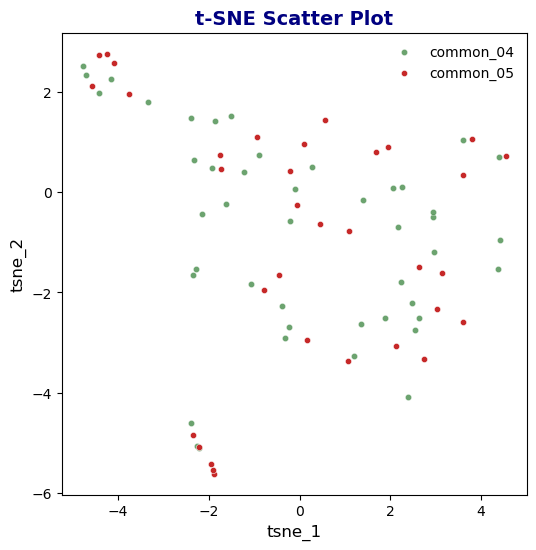

In [8]:
def plot_tsne_scatter(tsne_df, unique_tags, colors, alphas):
    plt.figure(figsize=(6, 6))
    ax = None
    for tag in unique_tags:
        color = colors[tag]
        alpha = alphas[tag]
        ax = sns.scatterplot(data=tsne_df.query(f"TAG == '{tag}'"), x="TSNE_1", y="TSNE_2", color=color, label=tag, alpha=alpha, s=20, ax=ax)

    ax.set_xlabel("tsne_1", fontsize=12)
    ax.set_ylabel("tsne_2", fontsize=12)
    ax.tick_params(axis='both', which='both', labelsize=10)
    ax.legend(fontsize=10, loc='upper right', frameon=False)

    plt.title("t-SNE Scatter Plot", fontsize=14, fontweight='bold', color='navy')
    plt.savefig("tsne_scatter.png", bbox_inches='tight')
    plt.show()

unique_tags = tsne_df['TAG'].unique()
colors = {unique_tags[0]: '#2e7d32', unique_tags[1]: '#c62828'}
alphas = {unique_tags[0]: 0.7,       unique_tags[1]: 1}

plot_tsne_scatter(tsne_df, unique_tags, colors, alphas)

<div style="background-color:#4B6587; color:#F0E5CF; padding: 1px; border-radius: 10px;">
    <h2 style="font-size: 16px; margin-left: 10px;"> t-SNE k-means Clustering </h2>
</div>

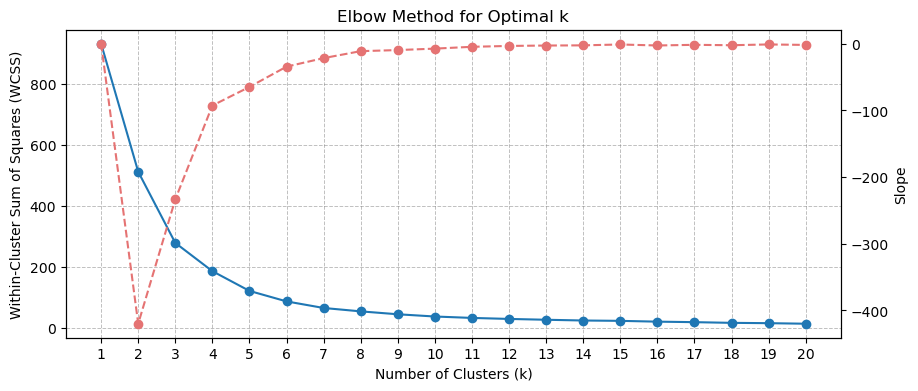

In [29]:
import numpy as np

kmeans_tsne = tsne_df.drop(['TAG', 'SMILES'], axis=1)
wcss = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(kmeans_tsne)
    wcss.append(kmeans.inertia_)

slopes = [0]  
for i in range(1, len(wcss)):
    slope = (wcss[i] - wcss[i - 1]) / (i - (i - 1))
    slopes.append(slope)

plt.figure(figsize=(10, 4))
plt.plot(range(1, 21), wcss, marker='o', linestyle='-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.grid(True, which='both', linestyle='--', linewidth='0.7', color='gray', alpha=0.5)
plt.xticks(range(1, 21))

plt.twinx()
plt.plot(range(1, 21), slopes, marker='o', linestyle='--', color='#e57373')
plt.ylabel('Slope')
plt.savefig('elbow_curve_with_slope.png', bbox_inches='tight')
plt.show()

In [30]:
def identify_elbow(wcss):
    deltas = np.diff(wcss)
    second_deltas = np.diff(deltas)
    elbow_index = np.where(second_deltas > 0)[0][0] + 1
    return elbow_index

elbow_index = identify_elbow(wcss)
optimal_k = elbow_index + 1  

print(f"The elbow point is at k={optimal_k}")

The elbow point is at k=2


In [9]:
tsne_clusters = tsne_df.copy()

kmeans = KMeans(n_clusters=8, random_state=42) 
tsne_clusters['cluster'] = kmeans.fit_predict(tsne_clusters[['TSNE_1', 'TSNE_2']])

cluster_centroids = kmeans.cluster_centers_
cluster_centroid_mapping = {cluster_id: centroid for cluster_id, centroid in enumerate(cluster_centroids)}
tsne_clusters['Cluster Centroid'] = tsne_clusters['cluster'].map(cluster_centroid_mapping)

def euclidean_distance(x1, y1, x2, y2):
    return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

tsne_clusters['distance from centroid'] = tsne_clusters.apply(lambda row: euclidean_distance(row['TSNE_1'], row['TSNE_2'], row['Cluster Centroid'][0], row['Cluster Centroid'][1]), axis=1)

tsne_clusters = tsne_clusters.sort_values(by=['cluster', 'distance from centroid'])

tsne_clusters['molecules_in_cluster_rankwise'] = tsne_clusters.groupby('cluster').cumcount() + 1
tsne_clusters['molecules_in_cluster_rankwise'] = 'cluster_' + tsne_clusters['cluster'].astype(str) + '_rank_' + tsne_clusters['molecules_in_cluster_rankwise'].astype(str)

print(tsne_clusters['cluster'].value_counts())

cluster_counts = tsne_clusters['cluster'].value_counts()
ranks_to_keep = []
for i in range(8):
    cluster_size = cluster_counts[i]
    j_range = range(1, cluster_size, (cluster_size//3))  
    ranks_to_keep.extend([f'cluster_{i}_rank_{j}' for j in j_range])

tsne_clusters = tsne_clusters[tsne_clusters['molecules_in_cluster_rankwise'].isin(ranks_to_keep)]
tsne_clusters = tsne_clusters.drop(tsne_clusters.index[-1])

display(tsne_clusters.head())
print(tsne_clusters.shape)

1    13
3    12
6    12
0    10
7    10
2     9
4     8
5     5
Name: cluster, dtype: int64


,TSNE_1,TSNE_2,Name,TAG,SMILES,cluster,Cluster Centroid,distance from centroid,molecules_in_cluster_rankwise
3,-4.162689,2.257764,curia2421,common_04,Cn1nc(C(=O)N2CCC3(CN(C(=O)O3)c3cc(Cl)ccc3)CC2)...,0,"[-4.246065, 2.2966418]",0.091995,cluster_0_rank_1
45,-4.571684,2.103752,curia2424,common_05,Cc1ccc(c(C)c1)S(=O)(=O)N1CCC2(CN(C(=O)O2)c2cc(...,0,"[-4.246065, 2.2966418]",0.378463,cluster_0_rank_4
2,-4.709970,2.322982,curia2415,common_04,Cn1nc(C(=O)N2CCC3(CN(C(=O)O3)c3ncccc3)CC2)c2c1...,0,"[-4.246065, 2.2966418]",0.464653,cluster_0_rank_7
55,2.124560,-3.066047,curia7795,common_05,CC(=O)N1CCC(CC1)n1c(=O)[nH]c2c(ncnc12)c1ccccc1C,1,"[2.2539892, -2.805036]",0.291339,cluster_1_rank_1
8,2.472125,-2.214505,curia6411,common_04,CN(C)C(=O)c1cc(ccc1)c1nc(ccn1)N1CCC(C1)N1Cc2cc...,1,"[2.2539892, -2.805036]",0.629531,cluster_1_rank_5


(25, 9)


In [12]:
tsne_clusters_25 = tsne_clusters[['Name', 'TAG','SMILES', 'molecules_in_cluster_rankwise']]
tsne_clusters_25.to_csv(f'../data/25_molecules_from_kmean_clustering_new.csv', index=False)

display(tsne_clusters_25.head(33))
print(tsne_clusters_25.shape)

,Name,TAG,SMILES,molecules_in_cluster_rankwise
3,curia2421,common_04,Cn1nc(C(=O)N2CCC3(CN(C(=O)O3)c3cc(Cl)ccc3)CC2)...,cluster_0_rank_1
45,curia2424,common_05,Cc1ccc(c(C)c1)S(=O)(=O)N1CCC2(CN(C(=O)O2)c2cc(...,cluster_0_rank_4
2,curia2415,common_04,Cn1nc(C(=O)N2CCC3(CN(C(=O)O3)c3ncccc3)CC2)c2c1...,cluster_0_rank_7
55,curia7795,common_05,CC(=O)N1CCC(CC1)n1c(=O)[nH]c2c(ncnc12)c1ccccc1C,cluster_1_rank_1
8,curia6411,common_04,CN(C)C(=O)c1cc(ccc1)c1nc(ccn1)N1CCC(C1)N1Cc2cc...,cluster_1_rank_5
15,curia0543,common_04,COc1cccc(c1)c1nc(C(=O)Nc2cccc3c2CCC3)c2CCOCCn12,cluster_1_rank_9
76,curia5311,common_05,COc1ccc2n(C3CCN(CC3)S(=O)(=O)c3ccc(C)c(C)c3)c(...,cluster_2_rank_1
51,curia7951,common_05,Cc1nc2c(o1)cc(cc2)C(=O)N1CCC(CC1)N1CC(OC1=O)c1...,cluster_2_rank_4
48,curia5231,common_05,Cc1cc(cc(F)c1)c1nc(ccc1)N1C[C@H]2OC(=O)N([C@@H...,cluster_2_rank_7
0,curia1063,common_04,Cc1ccc(NC(=O)N2CCC3(CC2)c2c(-c4cn(nc34)C3CCOCC...,cluster_3_rank_1


(25, 4)


In [70]:
print(tsne_clusters['cluster'].value_counts())

4    4
5    4
0    3
1    3
2    3
3    3
6    3
7    2
Name: cluster, dtype: int64


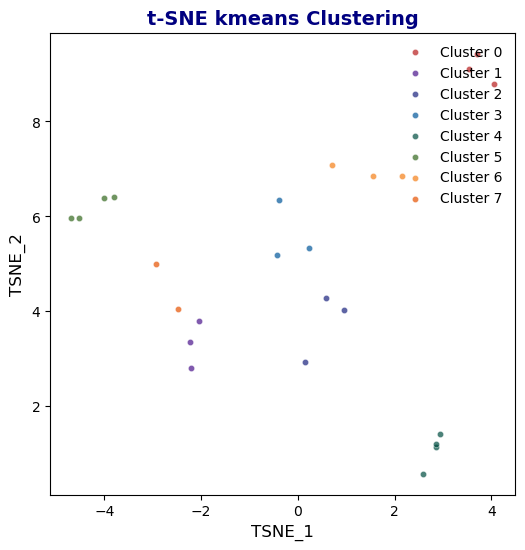

In [67]:
def plot_tsne_clusters(tsne_df, colors, alphas):
    plt.figure(figsize=(6, 6))
    ax = None
    for cluster in tsne_df['cluster'].unique():
        color = colors[cluster]
        alpha = alphas[cluster]
        ax = sns.scatterplot(data=tsne_df[tsne_df['cluster'] == cluster], x="TSNE_1", y="TSNE_2", color=color, label=f"Cluster {cluster}", alpha=alpha, s=20, ax=ax)

    ax.set_xlabel("TSNE_1", fontsize=12)
    ax.set_ylabel("TSNE_2", fontsize=12)
    ax.tick_params(axis='both', which='both', labelsize=10)
    ax.legend(fontsize=10, loc='upper right', frameon=False)

    plt.title("t-SNE kmeans Clustering", fontsize=14, fontweight='bold', color='navy')
    plt.savefig("tsne_kmeans_clustering.png", bbox_inches='tight')
    plt.show()

cluster_colors = {0: '#b71c1c', 1: '#4a148c', 2: '#1a237e', 3: '#01579b', 4: '#004d40', 5: '#33691e', 6: '#f57f17', 7: '#e65100', 8: '#3e2723', 9: '#263238'}
cluster_alphas = {0: 0.7, 1: 0.7, 2: 0.7, 3: 0.7, 4: 0.7, 5: 0.7, 6: 0.7, 7: 0.7, 8: 0.7, 9: 0.7}

plot_tsne_clusters(tsne_clusters, cluster_colors, cluster_alphas)

In [78]:
def plot_tsne_kde_clusters(tsne_clusters, colors, alphas):
    plt.figure(figsize=(6, 6))
    ax = None
    for cluster in tsne_clusters['cluster'].unique():
        color = colors[cluster]
        alpha = alphas[cluster]
        ax = sns.scatterplot(data=tsne_clusters[tsne_clusters['cluster'] == cluster], x="TSNE_1", y="TSNE_2", color=color, label=f"Cluster {cluster}", alpha=alpha, s=20, ax=ax)
        sns.kdeplot(data=tsne_clusters[tsne_clusters['cluster'] == cluster], x="TSNE_1", y="TSNE_2", cmap="Blues", shade=True, shade_lowest=False, alpha=0.3, ax=ax)

    ax.set_xlabel("TSNE_1", fontsize=12)
    ax.set_ylabel("TSNE_2", fontsize=12)
    ax.tick_params(axis='both', which='both', labelsize=10)
    ax.legend(fontsize=10, loc='upper right', frameon=False)

    plt.title("TSNE Gussian KMeans KDE", fontsize=14, fontweight='bold', color='navy')
    plt.savefig("tsne_gussian_kde.png", bbox_inches='tight')
    plt.show()

cluster_colors = {0: '#b71c1c', 1: '#4a148c', 2: '#1a237e', 3: '#01579b', 4: '#004d40', 5: '#33691e', 6: '#f57f17', 7: '#e65100', 8: '#3e2723', 9: '#263238'}
cluster_alphas = {0: 0.7, 1: 0.7, 2: 0.7, 3: 0.7, 4: 0.7, 5: 0.7, 6: 0.7, 7: 0.7, 8: 0.7, 9: 0.7}

plot_tsne_kde_clusters(tsne_clusters, cluster_colors, cluster_alphas)

KeyError: 0

<Figure size 600x600 with 0 Axes>

In [80]:
display(tsne_clusters.head())
print(tsne_clusters.shape)

,TSNE_1,TSNE_2,TAG,SMILES,cluster,Cluster Centroid,distance from centroid,molecules_in_cluster_rankwise
12,3.540444,9.100728,common_04,Fc1ccccc1C(=O)N1CCC2(C1)CN(C(=O)O2)c1ncccc1,0,"[3.725917, 8.958888]",0.233493,cluster_0_rank_1
45,4.056870,8.789370,common_05,Cc1ccc(c(C)c1)S(=O)(=O)N1CCC2(CN(C(=O)O2)c2cc(...,0,"[3.725917, 8.958888]",0.371842,cluster_0_rank_4
49,3.708090,9.434336,common_05,Cc1ccc(c(C)c1)S(=O)(=O)N1CCC2(CN(C(=O)O2)c2ccc...,0,"[3.725917, 8.958888]",0.475782,cluster_0_rank_7
22,-2.213786,2.798602,common_04,COc1cccc(c1)c1nn(nc1)C1CCN(CC1)C(=O)CCc1ccc(C)cc1,1,"[-1.9166199, 2.7837653]",0.297537,cluster_1_rank_1
8,-2.239210,3.338188,common_04,CN(C)C(=O)c1cc(ccc1)c1nc(ccn1)N1CCC(C1)N1Cc2cc...,1,"[-1.9166199, 2.7837653]",0.641443,cluster_1_rank_5


(25, 8)


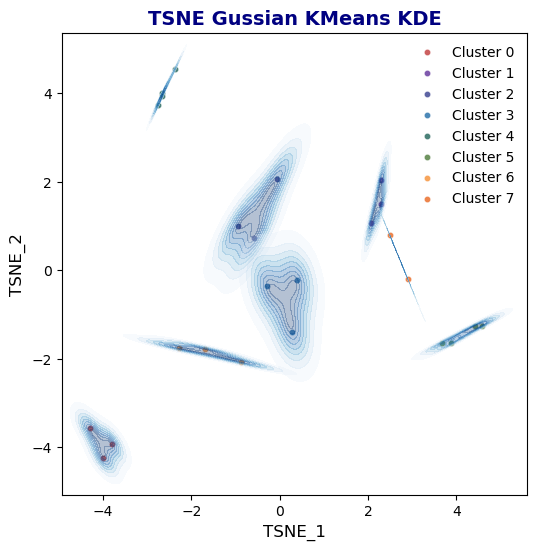

In [86]:
def plot_tsne_kde_clusters(tsne_clusters, colors, alphas):
    pca = PCA(n_components=2)
    tsne_pca = pca.fit_transform(tsne_clusters[['TSNE_1', 'TSNE_2']])
    tsne_clusters['PCA_TSNE_1'], tsne_clusters['PCA_TSNE_2'] = tsne_pca[:, 0], tsne_pca[:, 1]
    
    plt.figure(figsize=(6, 6))
    ax = None
    for cluster in tsne_clusters['cluster'].unique():
        color = colors[cluster]
        alpha = alphas[cluster]

        cluster_data = tsne_clusters[tsne_clusters['cluster'] == cluster]
        ax = sns.scatterplot(data=cluster_data, x="TSNE_1", y="TSNE_2", color=color, label=f"Cluster {cluster}", alpha=alpha, s=20, ax=ax)
        sns.kdeplot(data=cluster_data, x="TSNE_1", y="TSNE_2", cmap="Blues", shade=True, shade_lowest=False, alpha=0.3, ax=ax)
        
    ax.set_xlabel("TSNE_1", fontsize=12)
    ax.set_ylabel("TSNE_2", fontsize=12)
    ax.tick_params(axis='both', which='both', labelsize=10)
    ax.legend(fontsize=10, loc='upper right', frameon=False)

    plt.title("TSNE Gussian KMeans KDE", fontsize=14, fontweight='bold', color='navy')
    plt.savefig("tsne_gussian_kde.png", bbox_inches='tight')
    plt.show()

cluster_colors = {0: '#b71c1c', 1: '#4a148c', 2: '#1a237e', 3: '#01579b', 4: '#004d40', 5: '#33691e', 6: '#f57f17', 7: '#e65100', 8: '#3e2723', 9: '#263238'}
cluster_alphas = {0: 0.7, 1: 0.7, 2: 0.7, 3: 0.7, 4: 0.7, 5: 0.7, 6: 0.7, 7: 0.7, 8: 0.7, 9: 0.7}

plot_tsne_kde_clusters(tsne_clusters, cluster_colors, cluster_alphas)

<div style="background-color:#4B6587; color:#F0E5CF; padding: 1px; border-radius: 10px;">
    <h2 style="font-size: 16px; margin-left: 10px;"> t-SNE BKmeans Clustering </h2>
</div>

In [19]:
# !pip install bkmeans

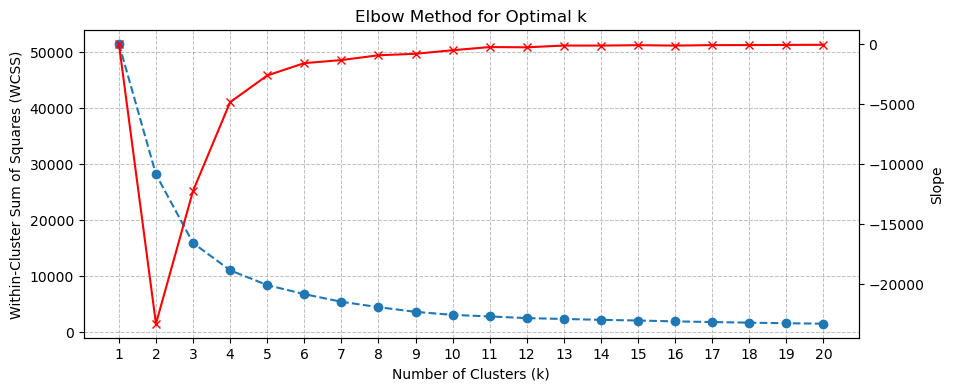

In [34]:
from bkmeans import BKMeans

bkmeans_tsne = tsne_df.drop(['TAG', 'SMILES'], axis=1)
wcss = []
for k in range(1, 21):
    bkmeans = BKMeans(n_clusters=k, random_state=0)
    bkmeans.fit(bkmeans_tsne)
    wcss.append(bkmeans.inertia_)
    
slopes = [0]  
for i in range(1, len(wcss)):
    slope = (wcss[i] - wcss[i - 1]) / (i - (i - 1))
    slopes.append(slope)

plt.figure(figsize=(10, 4))
plt.plot(range(1, 21), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.grid(True, which='both', linestyle='--', linewidth='0.7', color='gray', alpha=0.5)
plt.xticks(range(1, 21))

plt.twinx()
plt.plot(range(1, 21), slopes, marker='x', linestyle='-', color='red')
plt.ylabel('Slope')
plt.savefig('elbow_curve_with_slope.png', bbox_inches='tight')
plt.show()

In [21]:
def identify_elbow(wcss):
    deltas = np.diff(wcss)
    second_deltas = np.diff(deltas)
    elbow_index = np.where(second_deltas > 0)[0][0] + 1
    return elbow_index

elbow_index = identify_elbow(wcss)
optimal_k = elbow_index + 1  

print(f"The elbow point is at k={optimal_k}")

The elbow point is at k=2


In [22]:
tsne_clusters = tsne_df.copy()

bkmeans = BKMeans(n_clusters=2, random_state=42) 
tsne_clusters['cluster'] = bkmeans.fit_predict(tsne_clusters[['TSNE_1', 'TSNE_2']])

cluster_centroids = bkmeans.cluster_centers_
cluster_centroid_mapping = {cluster_id: centroid for cluster_id, centroid in enumerate(cluster_centroids)}
tsne_clusters['Cluster Centroid'] = tsne_clusters['cluster'].map(cluster_centroid_mapping)

def euclidean_distance(x1, y1, x2, y2):
    return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

tsne_clusters['distance from centroid'] = tsne_clusters.apply(lambda row: euclidean_distance(row['TSNE_1'], row['TSNE_2'], row['Cluster Centroid'][0], row['Cluster Centroid'][1]), axis=1)

tsne_clusters = tsne_clusters.sort_values(by=['cluster', 'distance from centroid'])

tsne_clusters['molecules_in_cluster_rankwise'] = tsne_clusters.groupby('cluster').cumcount() + 1
tsne_clusters['molecules_in_cluster_rankwise'] = 'cluster_' + tsne_clusters['cluster'].astype(str) + '_rank_' + tsne_clusters['molecules_in_cluster_rankwise'].astype(str)

ranks_to_keep = [f'cluster_{i}_rank_{j}' for i in range(2) for j in [1, 3, 9, 12, 15, 18, 21, 24, 27, 30]]
tsne_clusters = tsne_clusters[tsne_clusters['molecules_in_cluster_rankwise'].isin(ranks_to_keep)]

display(tsne_clusters.head())
print(tsne_clusters.shape)

,TSNE_1,TSNE_2,TAG,SMILES,cluster,Cluster Centroid,distance from centroid,molecules_in_cluster_rankwise
263,-0.207186,1.622895,common_5,Cc1ccc(F)c(c1)c1cc(NS(=O)(=O)c2cc3CC(=O)N4CCCc...,0,"[-6.464197, -0.35344383]",6.561715,cluster_0_rank_1
115,0.191497,2.568755,common_4,CC(=O)N1CCc2ccc(cc2CC1)S(=O)(=O)Nc1cc(n[nH]1)c...,0,"[-6.464197, -0.35344383]",7.268941,cluster_0_rank_3
203,2.851259,-5.761668,common_4,CC(N1CCN(CC1)S(=O)(=O)c1ccc2CCCc2c1)c1nc2ccccc...,0,"[-6.464197, -0.35344383]",10.771564,cluster_0_rank_9
281,5.021386,-1.497926,common_5,Cc1ccc2ncnc(Nc3cnn(Cc4nnc5CCCCn45)c3)c2c1,0,"[-6.464197, -0.35344383]",11.542463,cluster_0_rank_12
166,4.824963,-4.455103,common_4,OC1CNC(=O)C2(CCN(CC2)C(=O)Nc2cc(cc3NC(=O)COc23...,0,"[-6.464197, -0.35344383]",12.011192,cluster_0_rank_15


(20, 8)


In [23]:
print(tsne_clusters['cluster'].value_counts())

0    10
1    10
Name: cluster, dtype: int64


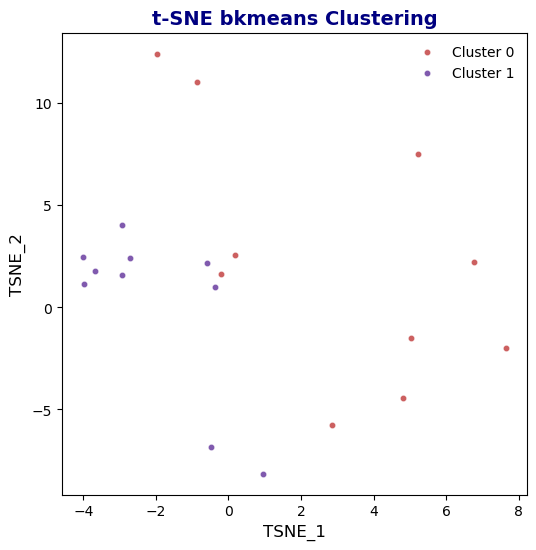

In [24]:
def plot_tsne_clusters(tsne_df, colors, alphas):
    plt.figure(figsize=(6, 6))
    ax = None
    for cluster in tsne_df['cluster'].unique():
        color = colors[cluster]
        alpha = alphas[cluster]
        ax = sns.scatterplot(data=tsne_df[tsne_df['cluster'] == cluster], x="TSNE_1", y="TSNE_2", color=color, label=f"Cluster {cluster}", alpha=alpha, s=20, ax=ax)

    ax.set_xlabel("TSNE_1", fontsize=12)
    ax.set_ylabel("TSNE_2", fontsize=12)
    ax.tick_params(axis='both', which='both', labelsize=10)
    ax.legend(fontsize=10, loc='upper right', frameon=False)

    plt.title("t-SNE bkmeans Clustering", fontsize=14, fontweight='bold', color='navy')
    # plt.savefig("tsne_bkmeans_clustering.png", bbox_inches='tight')
    plt.show()

cluster_colors = {0: '#b71c1c', 1: '#4a148c', 2: '#1a237e', 3: '#01579b', 4: '#004d40', 5: '#33691e', 6: '#f57f17', 7: '#e65100', 8: '#3e2723', 9: '#263238'}
cluster_alphas = {0: 0.7, 1: 0.7, 2: 0.7, 3: 0.7, 4: 0.7, 5: 0.7, 6: 0.7, 7: 0.7, 8: 0.7, 9: 0.7}

plot_tsne_clusters(tsne_clusters, cluster_colors, cluster_alphas)

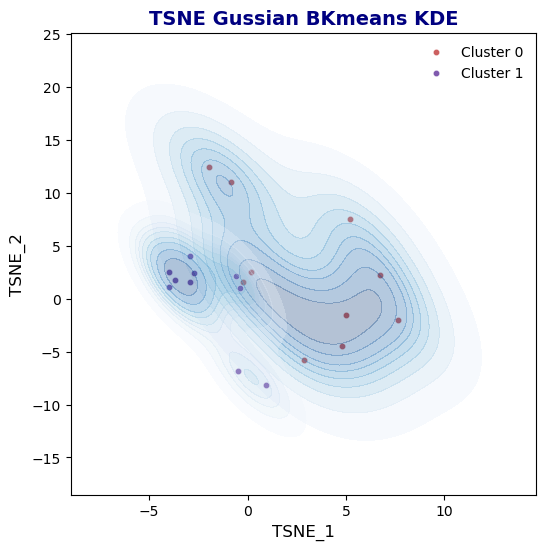

In [25]:
def plot_tsne_kde_clusters(tsne_df, colors, alphas):
    plt.figure(figsize=(6, 6))
    ax = None
    for cluster in tsne_df['cluster'].unique():
        color = colors[cluster]
        alpha = alphas[cluster]
        ax = sns.scatterplot(data=tsne_df[tsne_df['cluster'] == cluster], x="TSNE_1", y="TSNE_2", color=color, label=f"Cluster {cluster}", alpha=alpha, s=20, ax=ax)
        sns.kdeplot(data=tsne_df[tsne_df['cluster'] == cluster], x="TSNE_1", y="TSNE_2", cmap="Blues", shade=True, shade_lowest=False, alpha=0.3, ax=ax)

    ax.set_xlabel("TSNE_1", fontsize=12)
    ax.set_ylabel("TSNE_2", fontsize=12)
    ax.tick_params(axis='both', which='both', labelsize=10)
    ax.legend(fontsize=10, loc='upper right', frameon=False)

    plt.title("TSNE Gussian BKmeans KDE", fontsize=14, fontweight='bold', color='navy')
    # plt.savefig("tsne_gussian_kde.png", bbox_inches='tight')
    plt.show()

cluster_colors = {0: '#b71c1c', 1: '#4a148c', 2: '#1a237e', 3: '#01579b', 4: '#004d40', 5: '#33691e', 6: '#f57f17', 7: '#e65100', 8: '#3e2723', 9: '#263238'}
cluster_alphas = {0: 0.7, 1: 0.7, 2: 0.7, 3: 0.7, 4: 0.7, 5: 0.7, 6: 0.7, 7: 0.7, 8: 0.7, 9: 0.7}

plot_tsne_kde_clusters(tsne_clusters, cluster_colors, cluster_alphas)

<div style="background-color:#4B6587; color:#F0E5CF; padding: 1px; border-radius: 10px;">
    <h2 style="font-size: 16px; margin-left: 10px;"> UMAP (Uniform Manifold Approximation and Projection) </h2>
</div>

In [26]:
# def get_largest_fragment_from_smiles(s: str):
#     mol = Chem.MolFromSmiles(s)
#     return Chem.MolToSmiles(LargestFragmentChooser().choose(mol)) if mol else None

# def compute_ecfp_descriptors(smiles_list: List[str]):
#     keep_idx = []
#     descriptors = []
#     for i, smiles in enumerate(smiles_list):
#         ecfp = _compute_single_ecfp_descriptor(smiles)
#         if ecfp is not None:
#             keep_idx.append(i)
#             descriptors.append(ecfp)

#     return np.vstack(descriptors), keep_idx

# def _compute_single_ecfp_descriptor(smiles: str):
#     mol = Chem.MolFromSmiles(smiles)
#     return np.array(Chem.AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)) if mol else None

In [27]:
# df = pd.read_csv("clustering_top_molecules_minD_common_4_5.csv")

# umap_df = pd.DataFrame()
# umap_df["SMILES"] = df["SMILES"].apply(get_largest_fragment_from_smiles).dropna()
# ecfp_descriptors, keep_idx = compute_ecfp_descriptors(umap_df["SMILES"])
# umap_df = umap_df.iloc[keep_idx]

# umap_model = umap.UMAP(metric="euclidean", n_neighbors=25, n_components=2, low_memory=False, min_dist=0.001)
# X_umap = umap_model.fit_transform(ecfp_descriptors)

# umap_df["UMAP_1"], umap_df["UMAP_2"] = X_umap[:, 0], X_umap[:, 1]
# umap_df['TAG'] = df['TAG']
# display(umap_df.head())
# print(umap_df.shape)

In [28]:
# def plot_tsne_scatter(umap_df, unique_tags, colors, alphas):
#     plt.figure(figsize=(6, 6))
#     ax = None
#     for tag in unique_tags:
#         color = colors[tag]
#         alpha = alphas[tag]
#         ax = sns.scatterplot(data=umap_df.query(f"TAG == '{tag}'"), x="UMAP_1", y="UMAP_2", color=color, label=tag, alpha=alpha, s=20, ax=ax)

#     ax.set_xlabel("umap_1", fontsize=12)
#     ax.set_ylabel("umap_2", fontsize=12)
#     ax.tick_params(axis='both', which='both', labelsize=10)
#     ax.legend(fontsize=10, loc='upper right', frameon=False)

#     plt.title("UMAP Scatter Plot", fontsize=14, fontweight='bold', color='navy')
#     plt.savefig("umap_scatter.png", bbox_inches='tight')
#     plt.show()

# unique_tags = umap_df['TAG'].unique()
# colors = {unique_tags[0]: '#2e7d32', unique_tags[1]: '#c62828'}
# alphas = {unique_tags[0]: 0.7,       unique_tags[1]: 1}

# plot_tsne_scatter(umap_df, unique_tags, colors, alphas)

<div style="background-color:#4B6587; color:#F0E5CF; padding: 1px; border-radius: 10px;">
    <h2 style="font-size: 16px; margin-left: 10px;"> k-means Clustering </h2>
</div>

In [29]:
# kmean_df = umap_df.drop(['TAG', 'SMILES'], axis=1)
# wcss = []
# for k in range(1, 21):
#     kmeans = KMeans(n_clusters=k, random_state=0)
#     kmeans.fit(kmean_df)
#     wcss.append(kmeans.inertia_)

# plt.figure(figsize=(10, 4))
# plt.plot(range(1, 21), wcss, marker='o', linestyle='--')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
# plt.title('Elbow Method for Optimal k')
# plt.grid(True, which='both', linestyle='--', linewidth='0.7', color='gray', alpha=0.5)
# plt.xticks(range(1, 21))
# plt.savefig('elbow_curve.png', bbox_inches='tight')
# plt.show()

In [30]:
# kmeans = KMeans(n_clusters=10, random_state=42)  
# umap_df['cluster'] = kmeans.fit_predict(umap_df[['UMAP_1', 'UMAP_2']])
# umap_df.to_csv('umap_cluster.csv', index=False)
# display(umap_df.head())
# print(umap_df.columns)

In [31]:
# def plot_umap_clusters(umap_df, colors, alphas):
#     plt.figure(figsize=(6, 6))
#     ax = None
#     for cluster in umap_df['cluster'].unique():
#         color = colors[cluster]
#         alpha = alphas[cluster]
#         ax = sns.scatterplot(data=umap_df[tsne_df['cluster'] == cluster], x="UMAP_1", y="UMAP_2", color=color, label=f"Cluster {cluster}", alpha=alpha, s=20, ax=ax)

#     ax.set_xlabel("UMAP_1", fontsize=12)
#     ax.set_ylabel("UMAP_2", fontsize=12)
#     ax.tick_params(axis='both', which='both', labelsize=10)
#     ax.legend(fontsize=10, loc='upper right', frameon=False)

#     plt.title("UMAP kmeans Clustering", fontsize=14, fontweight='bold', color='navy')
#     plt.savefig("umap_kmeans_clustering.png", bbox_inches='tight')
#     plt.show()

# cluster_colors = {0: '#b71c1c', 1: '#4a148c', 2: '#1a237e', 3: '#01579b', 4: '#004d40', 5: '#33691e', 6: '#f57f17', 7: '#e65100', 8: '#3e2723', 9: '#263238'}
# cluster_alphas = {0: 0.7, 1: 0.7, 2: 0.7, 3: 0.7, 4: 0.7, 5: 0.7, 6: 0.7, 7: 0.7, 8: 0.7, 9: 0.7}

# plot_umap_clusters(umap_df, cluster_colors, cluster_alphas)

In [32]:
# def plot_umap_kde_clusters(umap_df, colors, alphas):
#     plt.figure(figsize=(6, 6))
#     ax = None
#     for cluster in umap_df['cluster'].unique():
#         color = colors[cluster]
#         alpha = alphas[cluster]
#         ax = sns.scatterplot(data=umap_df[umap_df['cluster'] == cluster], x="UMAP_1", y="UMAP_2", color=color, label=f"Cluster {cluster}", alpha=alpha, s=20, ax=ax)
#         sns.kdeplot(data=umap_df[umap_df['cluster'] == cluster], x="UMAP_1", y="UMAP_2", cmap="Blues", shade=True, shade_lowest=False, alpha=0.3, ax=ax)

#     ax.set_xlabel("UMAP_1", fontsize=12)
#     ax.set_ylabel("UMAP_2", fontsize=12)
#     ax.tick_params(axis='both', which='both', labelsize=10)
#     ax.legend(fontsize=10, loc='upper right', frameon=False)

#     plt.title("UMAP Gussian KDE", fontsize=14, fontweight='bold', color='navy')
#     plt.savefig("umap_gussian_kde.png", bbox_inches='tight')
#     plt.show()

# cluster_colors = {0: '#b71c1c', 1: '#4a148c', 2: '#1a237e', 3: '#01579b', 4: '#004d40', 5: '#33691e', 6: '#f57f17', 7: '#e65100', 8: '#3e2723', 9: '#263238'}
# cluster_alphas = {0: 0.7, 1: 0.7, 2: 0.7, 3: 0.7, 4: 0.7, 5: 0.7, 6: 0.7, 7: 0.7, 8: 0.7, 9: 0.7}

# plot_umap_kde_clusters(umap_df, cluster_colors, cluster_alphas)

In [33]:
# from PIL import Image, ImageDraw

# image_files = ['umap_scatter.png', 'umap_kmeans_clustering.png', 'umap_gussian_kde.png']

# images = [Image.open(file) for file in image_files]
# widths, heights = zip(*(img.size for img in images))

# border_size = 0  
# collage_width = sum(widths) + (len(images) - 1) * border_size + 2 * border_size  
# collage_height = max(heights)

# collage = Image.new('RGB', (collage_width, collage_height), (255, 255, 255))
# draw = ImageDraw.Draw(collage)

# x_offset = border_size  
# for idx, img in enumerate(images):
#     collage.paste(img, (x_offset, 0))
#     if idx < len(images) - 1:
#         draw.rectangle([(x_offset + img.width, 0), (x_offset + img.width + border_size, collage_height)], fill=(0, 0, 0))
#     x_offset += img.width + border_size

# collage.show()
# collage.save("umap_minD_top_molecules.png")